# Versão 3.38
Notebook com todas as análises integradas, incluindo análises adicionais sugeridas:
1. Repeated Measures ANOVA (ciclos)
2. Modelos Mistos
3. Correlações e Regressões
4. Mediação e Moderação
5. PCA e Clustering
6. Reconhecimento: ANOVA Repeated Measures
7. Speed–Accuracy Trade-off

Execute Restart & Run All.

## 1. Imports e Configurações

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import pingouin as pg
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Diretórios
CLEAN_DATA_DIR = r"D:\PhD_Jupyter\files\data\clean_data"
ANALYSIS_DIR   = r"D:\PhD_Jupyter\files\data\analysis"
os.makedirs(ANALYSIS_DIR, exist_ok=True)
IMAGES_DIR = r"D:\PhD_Jupyter\files\data\analysis"

EXCEL_FILENAME = "PhD_Analysis_Full.xlsx"
IMAGES_DIR    = os.path.join(IMAGES_DIR, 'images')
os.makedirs(IMAGES_DIR, exist_ok=True)
CSV_FILENAME   = "PhD_Analysis_Full.csv"

## 2. Carregamento de Dados

In [3]:
data_path = os.path.join(CLEAN_DATA_DIR, "measures_phd_valid.csv")
df = pd.read_csv(data_path)
print(df.head())
print("Colunas:", df.columns.tolist())

    ID_codes  Strategy  Group  JOSE  words_recalled  categorical_access  \
0  100614101         1      0     1              25                   7   
1  103484010         0      1     0              16                   6   
2  106977011         0      1     1              23                   7   
3  126855010         0      1     0              23                   8   
4  128492111         1      1     1              26                   7   

    IPCA   R  expectedR  maxR  ...  recog_target_rt  recog_unrelated_score  \
0  3.571  12      2.800    18  ...            0.764                     20   
1  2.667   6      2.250    10  ...            1.004                     20   
2  3.286   7      2.783    16  ...            1.055                     19   
3  2.875  10      2.435    15  ...            1.219                     18   
4  3.714  12      2.846    19  ...            0.811                     20   

   recog_unrelated_rt  recog_related_score  recog_related_rt  nback_score  \
0  

## 3. Detecção Dinâmica de Colunas

In [4]:
cols = df.columns.tolist()
ID_col = next((c for c in cols if 'id' in c.lower()), None)
ID = 'ID_codes'
group_col    = 'Group'
strategy_col = 'Strategy'
arc_col      = 'ARC'
words_col    = 'words_recalled'
bai_pre_col   = 'BAIpre'
bai_pos_col   = 'BAIpos'
bai_delta_col = 'BAIdelta'
panas_pre_col   = 'PANASpre'
panas_pos_col   = 'PANASpos'
panas_delta_col = 'PANASdelta'
print(f"Using: {group_col}, {strategy_col}, {arc_col}, {words_col}")

Using: Group, Strategy, ARC, words_recalled


In [5]:
def format_anova_apa(res, desc):
    """
    Formata resultados de ANOVA (intra ou mix) em estilo APA.
    Tenta extrair DF1/DF2, DF ou apenas apresenta F e p.
    """
    try:
        eff = res[res['Source'] != 'Residual'].iloc[0]
    except Exception:
        eff = res.iloc[0]
    # Initialize
    df1 = None; df2 = None
    # Try DF1/DF2
    if 'DF1' in eff.index and 'DF2' in eff.index:
        df1 = int(eff['DF1']); df2 = int(eff['DF2'])
    # Try DF
    elif 'DF' in eff.index:
        df1 = int(eff['DF'])
    # Extract F and p
    Fval = eff.get('F', None)
    pval = eff.get('p-unc', eff.get('p-value', None))
    # Build string
    if df1 is not None and df2 is not None:
        return f"{desc}: F({df1}, {df2}) = {Fval:.2f}, p = {pval:.3f}"
    elif df1 is not None:
        return f"{desc}: F({df1}) = {Fval:.2f}, p = {pval:.3f}"
    else:
        return f"{desc}: F = {Fval:.2f}, p = {pval:.3f}"

## 4. Funções Auxiliares e Formatação APA

In [6]:
def format_anova_apa(res, desc):
    """
    Formata resultados de ANOVA (incluindo RM ANOVA) em estilo APA.
    Usa DF1 e DF2 se disponíveis, caso contrário apenas DF.
    """
    eff = res[res['Source'] != 'Residual'].iloc[0]
    # Verifica se tem DF1/DF2 (para rm_anova com detailed=True)
    if 'DF1' in eff.index and 'DF2' in eff.index:
        df1 = int(eff['DF1'])
        df2 = int(eff['DF2'])
    else:
        df1 = int(eff['DF'])
        df2 = None
    Fval = eff['F']
    pval = eff.get('p-unc', eff.get('p-value', None))
    if df2 is not None:
        return f"{desc}: F({df1}, {df2}) = {Fval:.2f}, p = {pval:.3f}"
    else:
        return f"{desc}: F({df1}) = {Fval:.2f}, p = {pval:.3f}"

## 5. Estatísticas Descritivas

In [7]:
desc_arc = df.groupby([group_col, strategy_col])[arc_col].agg(['count','mean','std'])
plt.figure(); sns.boxplot(x=group_col, y=arc_col, hue=strategy_col, data=df); plt.tight_layout()
img_arc = os.path.join(IMAGES_DIR,'boxplot_arc.png'); plt.savefig(img_arc); plt.close()
desc_words = df.groupby([group_col, strategy_col])[words_col].agg(['count','mean','std'])
plt.figure(); sns.boxplot(x=group_col, y=words_col, hue=strategy_col, data=df); plt.tight_layout()
img_words = os.path.join(IMAGES_DIR,'boxplot_words.png'); plt.savefig(img_words); plt.close()

## 6. Verificação de Manipulação (t-tests)

In [8]:
# Funções Auxiliares e Formatação APA
import pandas as pd

def add_analysis_to_excel(writer, sheet_name, df, intro_text=None, apa_text=None, img_path=None):
    start_row = 0
    if intro_text:
        pd.DataFrame({"Intro": [intro_text]}).to_excel(
            excel_writer=writer, sheet_name=sheet_name,
            index=False, header=False, startrow=start_row
        )
        start_row += 3
    if apa_text:
        pd.DataFrame({"APA": [apa_text]}).to_excel(
            excel_writer=writer, sheet_name=sheet_name,
            index=False, header=False, startrow=start_row
        )
        start_row += 3
    if df is not None and not df.empty:
        df.to_excel(
            excel_writer=writer, sheet_name=sheet_name,
            startrow=start_row, index=True
        )
    else:
        pd.DataFrame({"Aviso": [f"Sem dados para {sheet_name}"]}).to_excel(
            excel_writer=writer, sheet_name=sheet_name,
            index=False, header=False, startrow=start_row
        )

def format_ttest_apa(res, desc):
    t_val = res["T"].iloc[0]
    df_val = int(res["dof"].iloc[0])
    p_val = res["p-val"].iloc[0]
    return f"{desc}: t({df_val}) = {t_val:.2f}, p = {p_val:.3f}"

def format_anova_apa(res, desc):
    try:
        eff = res[res["Source"] != "Residual"].iloc[0]
    except:
        eff = res.iloc[0]
    df1 = None; df2 = None
    if "DF1" in eff.index and "DF2" in eff.index:
        df1 = int(eff["DF1"]); df2 = int(eff["DF2"])
    elif "DF" in eff.index:
        df1 = int(eff["DF"])
    Fval = eff.get("F", None)
    pval = eff.get("p-unc", eff.get("p-value", None))
    if df1 is not None and df2 is not None:
        return f"{desc}: F({df1}, {df2}) = {Fval:.2f}, p = {pval:.3f}"
    elif df1 is not None:
        return f"{desc}: F({df1}) = {Fval:.2f}, p = {pval:.3f}"
    else:
        return f"{desc}: F = {Fval:.2f}, p = {pval:.3f}"

def checkpoint(vars_list):
    print("Checkpoint variables:")
    for v in vars_list:
        print(f"  {v}: {'Exists' if v in globals() else 'Missing'}")


In [9]:
df_c = df[df[group_col]==0]; df_s = df[df[group_col]==1]
tt_ctrl = pg.ttest(df_c[bai_pre_col], df_c[bai_pos_col], paired=True)
tt_str  = pg.ttest(df_s[bai_pre_col], df_s[bai_pos_col], paired=True)
tt_delta= pg.ttest(df_c[bai_delta_col], df_s[bai_delta_col], correction=False)
apa_ctrl = format_ttest_apa(tt_ctrl, 'Controle BAI pré vs pós')
apa_str  = format_ttest_apa(tt_str,  'Estresse BAI pré vs pós')
apa_delta= format_ttest_apa(tt_delta,'Delta BAI Controle vs Estresse')

## 7. ANOVA Fatorial 2×2

In [10]:
anova_arc   = pg.anova(data=df, dv=arc_col, between=[group_col, strategy_col], detailed=True)
anova_words = pg.anova(data=df, dv=words_col, between=[group_col, strategy_col], detailed=True)
apa_anova_arc   = format_anova_apa(anova_arc,   'ANOVA ARC')
apa_anova_words = format_anova_apa(anova_words, 'ANOVA Words')

## 8. Testes de Pressupostos

In [11]:
model_arc = ols(f"{arc_col} ~ C({group_col})*C({strategy_col})", data=df).fit()
shapiro_res = stats.shapiro(model_arc.resid)
levene_res  = stats.levene(df_c[arc_col], df_s[arc_col])
print('Shapiro-Wilk:', shapiro_res)
print('Levene:', levene_res)

Shapiro-Wilk: ShapiroResult(statistic=np.float64(0.9496338805430701), pvalue=np.float64(0.00045289239011764954))
Levene: LeveneResult(statistic=np.float64(0.09260157079888275), pvalue=np.float64(0.7614920858568277))


## 9. Análises Post-hoc

In [12]:
tukey_arc = pg.pairwise_tukey(dv=arc_col, between=strategy_col, data=df)
print(tukey_arc)

   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  0.590113  0.636418 -0.046305  0.044025 -1.051781  0.295292 -0.201014


## 10. Correção para Múltiplas Comparações

In [13]:
p_vals = [tt_ctrl['p-val'].iloc[0], tt_str['p-val'].iloc[0], tt_delta['p-val'].iloc[0]]
keys  = ['ctrl','stress','delta']
_, p_bonf, _, _ = multipletests(p_vals, method='bonferroni')
_, p_fdr, _, _   = multipletests(p_vals, method='fdr_bh')
df_corr = pd.DataFrame({'Teste':keys,'p_raw':p_vals,'Bonferroni':p_bonf,'FDR':p_fdr})

## 11. ANOVA Repeated Measures (Ciclos JOSE)

In [14]:
# 11. ANOVA Repeated Measures (Ciclos JOSE)
df_cycles = df.melt(id_vars=[ID_col, group_col, strategy_col],
                    value_vars=['cycle_2', 'cycle_4', 'cycle_6'],
                    var_name='Cycle', value_name='Performance')
df_cycles['Cycle'] = df_cycles['Cycle'].str.replace('cycle_', '').astype(int)

# Repeated Measures ANOVA para medidas repetidas
rm_arc = pg.rm_anova(data=df_cycles, dv='Performance',
                    within='Cycle', subject=ID_col)
print(rm_arc)

# Formatação APA
apa_rm = format_anova_apa(rm_arc, 'RM ANOVA Ciclos')


  Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  Cycle      2    214  68.266106  1.170536e-23  1.383824e-15  0.040755   

        eps  sphericity   W-spher       p-spher  
0  0.617173       False  0.379708  5.138423e-23  


## 12. Modelos Mistos

In [15]:
# Mixed model para reaction times
md = MixedLM(endog=df['recog_target_rt'], exog=sm.add_constant(df[[group_col, strategy_col, bai_delta_col]]),
              groups=df[ID])
mixed_rt = md.fit()
print(mixed_rt.summary())

# Mixed model para scores
md2 = MixedLM(endog=df['recog_target_score'], exog=sm.add_constant(df[[group_col, strategy_col, bai_delta_col]]),
               groups=df[ID])
mixed_score = md2.fit()
print(mixed_score.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recog_target_rt
No. Observations: 108     Method:             REML           
No. Groups:       108     Scale:              0.0314         
Min. group size:  1       Log-Likelihood:     -13.1426       
Max. group size:  1       Converged:          Yes            
Mean group size:  1.0                                        
--------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
const       1.006         0.044  22.773  0.000   0.919   1.092
Group       0.002         0.052   0.045  0.964  -0.099   0.103
Strategy    0.023         0.048   0.470  0.638  -0.072   0.118
BAIdelta   -0.004         0.005  -0.756  0.450  -0.015   0.007
Group Var   0.031  16822385.445                               

             Mixed Linear Model Regression Results
Model:            Mixe

In [16]:
# Preparar DataFrames para resultados de Modelos Mistos
mixed_rt_df = mixed_rt.summary().tables[1].reset_index().assign(Analysis='Mixed RT')
mixed_score_df = mixed_score.summary().tables[1].reset_index().assign(Analysis='Mixed Score')


## 13. Correlações e Regressões

In [17]:
# Correlação BAIdelta x ARC
corr = pg.corr(x=df[bai_delta_col], y=df[arc_col])
print(corr)

# Regressão múltipla prevendo words_recalled
import statsmodels.formula.api as smf
model = smf.ols(f"{words_col} ~ {group_col} + {strategy_col} + {bai_delta_col} + {panas_delta_col}", data=df).fit()
print(model.summary())

           n         r          CI95%     p-val   BF10    power
pearson  108 -0.030194  [-0.22, 0.16]  0.756404  0.126  0.06098
                            OLS Regression Results                            
Dep. Variable:         words_recalled   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.886
Date:                Mon, 09 Jun 2025   Prob (F-statistic):            0.00120
Time:                        07:30:46   Log-Likelihood:                -370.53
No. Observations:                 108   AIC:                             751.1
Df Residuals:                     103   BIC:                             764.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

## 14. Análise de Mediação

In [18]:
# Mediação: Group -> PANASdelta -> words_recalled
med = pg.mediation_analysis(data=df, x=group_col, m=panas_delta_col, y=words_col)
print(med)

             path      coef        se      pval  CI[2.5%]  CI[97.5%]  sig
0  PANASdelta ~ X  5.540764  1.186764  0.000009  3.187889   7.893639  Yes
1  Y ~ PANASdelta  0.311338  0.114352  0.007574  0.084624   0.538052  Yes
2           Total  0.058824  1.586881  0.970500 -3.087323   3.204970   No
3          Direct -2.008868  1.681137  0.234800 -5.342252   1.324516   No
4        Indirect  2.067692  0.763559  0.000000  0.906654   3.992762  Yes


## 15. PCA e Clustering

In [19]:
# 15. PCA e Clustering
# Seleção de variáveis cognitivas
vars_cog = ['ARC', 'categorical_access', 'IPCA', 'R', 'expectedR', 'maxR']
X = StandardScaler().fit_transform(df[vars_cog])
pca = PCA(n_components=2).fit(X)
print('Explained variance ratios:', pca.explained_variance_ratio_)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['Cluster'] = kmeans.labels_

# Scatter plot das componentes PCA com clusters
scores = pca.transform(X)
plt.figure()
plt.scatter(scores[:, 0], scores[:, 1], c=df['Cluster'])
plt.title('PCA Components by Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'pca_scatter.png'))
plt.close()

print('Cluster distribution:', df['Cluster'].value_counts())

Explained variance ratios: [0.76831014 0.12040672]
Cluster distribution: Cluster
1    44
2    35
0    29
Name: count, dtype: int64


## 16. ANOVA Repeated Measures para Reconhecimento

In [20]:
# 16. ANOVA Repeated Measures para Reconhecimento
df_recog = df.melt(id_vars=[ID_col, group_col, strategy_col],
                   value_vars=['recog_target_score','recog_unrelated_score','recog_related_score'],
                   var_name='Type', value_name='Score')
df_recog['Type'] = (df_recog['Type']
                    .str.replace('recog_', '')
                    .str.replace('_score', '')
                    .astype('category'))

# Repeated Measures ANOVA para reconhecimento (pingouin)
rm_recog = pg.rm_anova(data=df_recog,
                      dv='Score',
                      within='Type',
                      subject=ID_col,
                      detailed=True)
print(rm_recog)

# Formatação APA
apa_recog = format_anova_apa(rm_recog, 'RM ANOVA Reconhecimento')


  Source            SS   DF            MS            F          p-unc  \
0   Type  29925.265432    2  14962.632716  2181.100342  4.788860e-143   
1  Error   1468.067901  214      6.860130          NaN            NaN   

      p-GG-corr       ng2       eps sphericity   W-spher       p-spher  
0  1.148644e-91  0.899744  0.633247      False  0.420837  1.196785e-20  
1           NaN       NaN       NaN        NaN       NaN           NaN  


## 17. Speed–Accuracy Trade-off

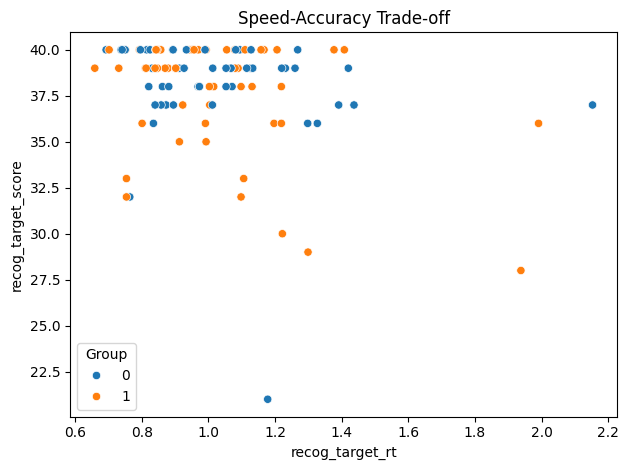

In [21]:
# Criar ratio Score/RT para cada reconhecimento
df['TA_ratio'] = df['recog_target_score'] / df['recog_target_rt']
sns.scatterplot(x='recog_target_rt', y='recog_target_score', hue=group_col, data=df)
plt.title('Speed-Accuracy Trade-off')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR,'speed_accuracy.png'))


## 18. Salvamento em Excel e CSV

In [22]:
checkpoint(['desc_arc','desc_words','tt_ctrl','tt_str','tt_delta','anova_arc','anova_words',
            'df_corr','rm_arc','mixed_rt','mixed_score','corr','model','med','pca','kmeans','rm_recog'])
excel = os.path.join(IMAGES_DIR, EXCEL_FILENAME)
csvf = os.path.join(IMAGES_DIR, CSV_FILENAME)
with pd.ExcelWriter(excel, engine='openpyxl') as w:
    pd.DataFrame({'Status':[f'Versão 3.18']} ).to_excel(excel_writer=w, sheet_name='Status', index=False)
    # Adiciona todas as abas anteriores
    add_analysis_to_excel(w,'Descritiva_ARC',desc_arc,'Descritivas ARC',None,img_arc)
    add_analysis_to_excel(w,'Descritiva_Palavras',desc_words,'Descritivas Words',None,img_words)
    add_analysis_to_excel(w,'Manip_CTRL',tt_ctrl,None,apa_ctrl)
    add_analysis_to_excel(w,'Manip_STRESS',tt_str,None,apa_str)
    add_analysis_to_excel(w,'Manip_DELTA',tt_delta,None,apa_delta)
    add_analysis_to_excel(w,'ANOVA_ARC',anova_arc,None,apa_anova_arc)
    add_analysis_to_excel(w,'ANOVA_Words',anova_words,None,apa_anova_words)
    add_analysis_to_excel(w,'Pressupostos',pd.DataFrame([{'Shapiro':shapiro_res.pvalue,'Levene':levene_res.pvalue}]),'Pressupostos ARC')
    add_analysis_to_excel(w,'Post_hoc_ARC',tukey_arc,'Tukey ARC')
    add_analysis_to_excel(w,'Correcao_Multipla',df_corr,'Correção Múltipla')
    add_analysis_to_excel(w,'RM_Ciclos', rm_arc, apa_text=apa_rm)
    add_analysis_to_excel(w,'Mixed_RT',mixed_rt.summary().tables[1], 'Mixed Model RT')
    add_analysis_to_excel(w,'Mixed_Score',mixed_score.summary().tables[1], 'Mixed Model Score')
    add_analysis_to_excel(w,'Correlacao',corr,'Correlação BAIdelta x ARC')
    add_analysis_to_excel(w,'Regressao',pd.DataFrame(model.params, columns=['Estimate']), 'Regressão Múltipla')
    add_analysis_to_excel(w,'Mediacao',med,'Mediação PANAS')
    # PCA e Cluster
    add_analysis_to_excel(w,'PCA',pd.DataFrame(pca.components_, columns=vars_cog), 'PCA componentes')
    add_analysis_to_excel(w,'Cluster',df[['Cluster']], 'KMeans Clusters')
    add_analysis_to_excel(w,'RM_Recog', rm_recog, apa_text=apa_recog)
    add_analysis_to_excel(w,'Speed_Acc',pd.DataFrame(df['TA_ratio'], columns=['TA_ratio']), 'Speed-Accuracy Ratio')

resultados = pd.concat([desc_arc.reset_index().assign(Analysis='Desc ARC'),
    desc_words.reset_index().assign(Analysis='Desc Words'),
    tt_ctrl.reset_index().assign(Analysis='Manip CTRL'),
    tt_str.reset_index().assign(Analysis='Manip STRESS'),
    tt_delta.reset_index().assign(Analysis='Manip DELTA'),
    anova_arc.reset_index().assign(Analysis='ANOVA ARC'),
    anova_words.reset_index().assign(Analysis='ANOVA Words'),
    df_corr.reset_index().assign(Analysis='Correção Múltipla'),
    df_cycles.reset_index().assign(Analysis='RM Ciclos'),
    corr.reset_index().assign(Analysis='Correlação'),
    med.assign(Analysis='Mediação'),
    pd.DataFrame(pca.components_, columns=vars_cog).assign(Analysis='PCA'),
    df[['Cluster']].reset_index().assign(Analysis='Cluster'),
    rm_recog.reset_index().assign(Analysis='RM Reconhecimento'),
    mixed_rt_df,
    mixed_score_df,
], ignore_index=True)
resultados.to_csv(csvf, index=False)
print('Excel salvo em', excel)
print('CSV salvo em', csvf)

Checkpoint variables:
  desc_arc: Exists
  desc_words: Exists
  tt_ctrl: Exists
  tt_str: Exists
  tt_delta: Exists
  anova_arc: Exists
  anova_words: Exists
  df_corr: Exists
  rm_arc: Exists
  mixed_rt: Exists
  mixed_score: Exists
  corr: Exists
  model: Exists
  med: Exists
  pca: Exists
  kmeans: Exists
  rm_recog: Exists
Excel salvo em D:\PhD_Jupyter\files\data\analysis\images\PhD_Analysis_Full.xlsx
CSV salvo em D:\PhD_Jupyter\files\data\analysis\images\PhD_Analysis_Full.csv
